In [1]:
from astropy.visualization import simple_norm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import numpy as np
import warnings
import glob
import os

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#optional theme for jupyter plots
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [5]:
os.chdir('/Users/felipegran/Desktop/Doctorado/ESO/CL03/comb/')

In [13]:
names = ['n','x','y','RAJ2000','DEJ2000','psf_mag','psf_mag_error','ape_mag','ape_mag_error','fwhm','flags','snr']
v = pd.read_csv('cmds_output/v.psf.cat', comment='#', delim_whitespace=True, names=names)
r = pd.read_csv('cmds_output/r.psf.cat', comment='#', delim_whitespace=True, names=names)
i = pd.read_csv('cmds_output/i.psf.cat', comment='#', delim_whitespace=True, names=names)

print('N stars in each band: V:%d R:%d I:%d' %(v.x.size, r.x.size, i.x.size))

N stars in each band: V:420 R:420 I:420


In [14]:
image = fits.open('IMAGE_FOV_0004.fits')

data = image[1].data
data = np.nan_to_num(data)
data[data < 0] = 0

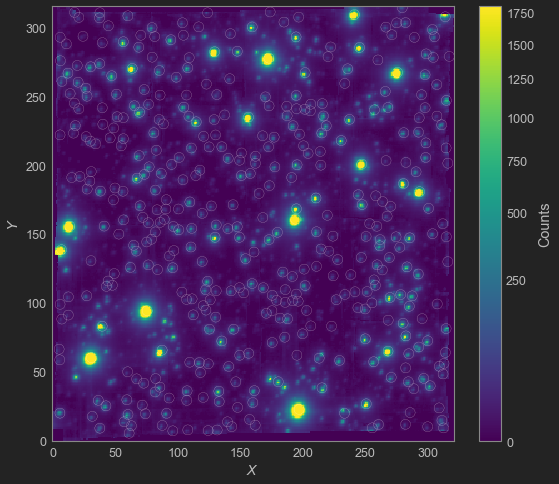

In [16]:
plt.figure(figsize=(9,8))

plt.scatter(v.x, v.y, marker='o', facecolor='None', color='w', s=100)
#plt.scatter(r.x, r.y, color='w', marker='o', facecolor='None', s=100)
#plt.scatter(i.x, i.y, color='g', marker='o', facecolor='None', s=150)

norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.grid(False)
plt.show()

In [40]:
pix_to_asec = 0.2 #arcsec/pix MUSE pixel scale

In [22]:
filter_nan = (v.psf_mag != 99.) & (r.psf_mag != 99.) & (i.psf_mag != 99.) & (v.psf_mag_error != 99.) & (v.psf_mag_error != 99.) & (v.psf_mag_error != 99.)

In [24]:
v = v[filter_nan]
r = r[filter_nan]
i = i[filter_nan]

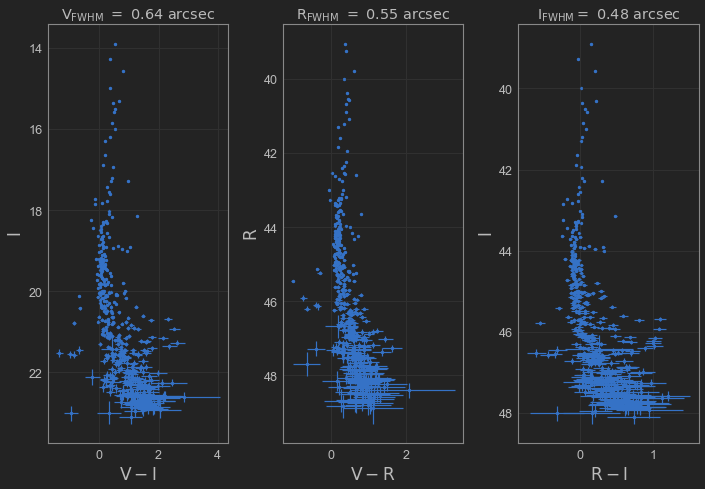

In [27]:
plt.figure(figsize=(10,7))

plt.subplot(1,3,1)
plt.scatter(v.psf_mag-i.psf_mag, i.psf_mag, s=10)
plt.errorbar(v.psf_mag-i.psf_mag, i.psf_mag, yerr=i.psf_mag_error, xerr=(v.psf_mag_error**2.+i.psf_mag_error**2.)**0.5, fmt='.')
plt.title(r'${\rm V_{FWHM}\ =\ %1.2f\ arcsec}$' %np.median(v.fwhm[v.fwhm != 0.]*pix_to_asec))
plt.gca().invert_yaxis()
plt.xlabel(r'${\rm V-I}$', size=17)
plt.ylabel(r'${\rm I}$', size=17)

plt.subplot(1,3,2)
plt.scatter(v.psf_mag-r.psf_mag, r.psf_mag+25, s=10)
plt.errorbar(v.psf_mag-r.psf_mag, r.psf_mag+25, yerr=r.psf_mag_error, xerr=(v.psf_mag_error**2.+r.psf_mag_error**2.)**0.5, fmt='.')
plt.title(r'${\rm R_{FWHM}\ =\ %1.2f\ arcsec}$' %np.median(r.fwhm[r.fwhm != 0.]*pix_to_asec))
plt.gca().invert_yaxis()
plt.xlabel(r'${\rm V-R}$', size=17)
plt.ylabel(r'${\rm R}$', size=17)

plt.subplot(1,3,3)
plt.scatter(r.psf_mag-i.psf_mag, i.psf_mag+25, s=10)
plt.errorbar(r.psf_mag-i.psf_mag, i.psf_mag+25, yerr=i.psf_mag_error, xerr=(r.psf_mag_error**2.+i.psf_mag_error**2.)**0.5, fmt='.')
plt.title(r'${\rm I_{FWHM} =\ %1.2f\ arcsec}$' %np.median(i.fwhm[i.fwhm != 0.]*pix_to_asec))
plt.gca().invert_yaxis()
plt.xlabel(r'${\rm R-I}$', size=17)
plt.ylabel(r'${\rm I}$', size=17)

plt.tight_layout()
plt.savefig('cmds_output/CMDs.pdf')

In [30]:
data = glob.glob('fits/*.s*.fits')
img_name = 'DATACUBE_FINAL'

In [66]:
def sextractor(img,i_fwhm):
    
    img_name = img.split('.fits')[0].split('fits/')[1]
    
    cmd1 = 'sex -PARAMETERS_NAME default.param.ape -DETECT_THRESH %s -ANALYSIS_THRESH %s -PHOT_APERTURES %1.2f -CATALOG_TYPE FITS_LDAC -CATALOG_NAME %s.ldac %s,%s' %(detect_tresh,analysis_tresh,1.5*i_fwhm,img_name,reference_image,img)
    os.system('%s' %cmd1);
    cmd2 = 'psfex %s.ldac' %(img_name)
    os.system('%s' %cmd2);
    cmd3 = 'sex -PARAMETERS_NAME default.param.psf -DETECT_THRESH %s -ANALYSIS_THRESH %s -PHOT_APERTURES %1.2f -CATALOG_TYPE ASCII_HEAD -CATALOG_NAME %s.psf.cat -PSF_NAME %s.psf %s,%s' %(detect_tresh,analysis_tresh,1.5*i_fwhm,img_name,img_name,reference_image,img)
    os.system('%s' %cmd3); 
    
    os.system('mv samp_%s.fits slice_psfex_output/' %img_name)
    os.system('mv snap_%s.fits slice_psfex_output/' %img_name)
    os.system('mv resi_%s.fits slice_psfex_output/' %img_name)
    os.system('mv chi_%s.fits slice_psfex_output/' %img_name)
    os.system('mv proto_%s.fits slice_psfex_output/' %img_name)
    os.system('mv %s.psf slice_psfex_output/' %img_name)
    os.system('mv %s.ldac slice_psfex_output/' %img_name)
    
    os.system('mv %s.psf.cat slice_catalogs/' %img_name)

    pass

In [67]:
os.system('rm slice_catalogs/*.psf.cat');
os.system('rm slice_psfex_output/*.fits');
os.system('rm chi_* snap_* resi_* samp_* proto_*');

In [68]:
i_image = 'IMAGE_FOV_0004.fits'
reference_image = i_image
detect_tresh = 2.0
analysis_tresh = 2.0

In [69]:
i_fwhm = fits.open('%s' %i_image)[0].header['HIERARCH ESO OCS SGS FWHM MED']/pix_to_asec 
Parallel(n_jobs=-1, verbose=1)(delayed(sextractor)(img,i_fwhm) for img in data);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 3721 out of 3721 | elapsed: 50.4min finished


In [72]:
#Read all the slice catalogs 
data = glob.glob('slice_catalogs/*.s*.cat')

In [73]:
%%time

phot = pd.DataFrame()
for n_slice,cat in enumerate(data):
    
    if n_slice == 0:
        names = ['n','x','y','RAJ2000','DEJ2000','psf_flux']
        phot = pd.read_csv('%s' %cat, comment='#', delim_whitespace=True, names=names, usecols=(0,1,2,3,4,5))
    else:
        names = ['n','psf_flux']
        phot_new = pd.read_csv('%s' %cat, comment='#', delim_whitespace=True, names=names, usecols=(0,5))
        phot = pd.merge(phot, phot_new, on='n')    

CPU times: user 1min 35s, sys: 54.7 s, total: 2min 30s
Wall time: 2min 47s


In [74]:
def wl(N, crpix, crdelt, crval):
    """
    N: numero del slice
    crpix: reference slice de inicio
    crdelt: delta lambda por cada slice
    crval: lambda de referencia/inicio
    """
    return (N+1-crpix)*crdelt + crval
CRPIX1 = 1.
CRDEL1 = 1.25
CRVAL1 = 4699.25
#(3721)*1.25+4699.625

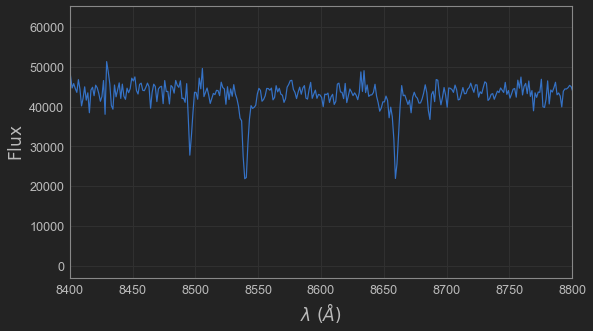

In [94]:
plt.figure(figsize=(9,5))

plt.plot(wl(np.arange(3721), CRPIX1, CRDEL1, CRVAL1),phot.values[1][5:])
plt.xlim(8400,8800)
plt.xlabel(r'$\lambda\ (\AA)$', size=17)
plt.ylabel(r'${\rm Flux}$', size=17)
plt.show()